In [36]:
from __future__ import print_function

import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from utils.postprocessing.config import Config
from ipywidgets import interact, interactive, fixed, interact_manual
from utils.visualisation import *
from utils.postprocessing.utils import *
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import gridspec

In [37]:
from utils.visualisation import VisualiseSimulation

In [38]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%%html
<style>

div.output_scroll {
    height : auto;
}
</style>

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [40]:
def folder2maps(folder):
    maps = glob.glob('/home/francesco/Documents/Master-Thesis/core/maps/{}/*.png'.format(folder))
    return maps, list(map(lambda x : path.splitext(path.basename(x))[0], maps))


def map2dfs(map_name, mode):
    hm = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}/{}.png'.format(mode, map_name))
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
    
    csvs_dir = '/home/francesco/Desktop/carino/vaevictis/data/{}/{}/csvs/{}/*.csv'.format(FOLDER, mode, map_name)
    print(csvs_dir)
    csvs_paths = glob.glob(csvs_dir)
    
    csvs_paths.sort()
    
    dfs = csvs2dfs(csvs_paths)
    print(len(dfs))
    return csvs_paths, dfs, hm

In [49]:
FOLDER = 'flat_spawns'
MODE = 'test'
MAP_NAME = 'flat'

In [7]:
map_pathes, map_names = folder2maps(FOLDER)

w2 = interactive(map2dfs, map_name=map_names)

display(w2)

ValueError: cannot find widget or abbreviation for argument: 'mode'

In [50]:
csvs_paths, dfs, hm  = map2dfs(MAP_NAME, MODE)

/home/francesco/Desktop/carino/vaevictis/data/flat_spawns/test/csvs/flat/*.csv
10


In [ ]:
csvs_paths, dfs, hm = w2.result

## Visualize the robot's trace
Below we plotted all the robot's positions for the given map

## Plotting statistics

In [32]:
# def clean_outliers_from_dfs(dfs, offset = 25):

offset = 10
dfs_clean = []

for df in dfs:
    index = df[(df['hm_y'] > (hm.shape[0] - offset)) | (df['hm_y'] <  offset) 
               | (df['hm_x'] > (hm.shape[1] - offset)) | (df['hm_x'] <  offset)
              ].index

    if len(index) > 0:
        idx = index[0]
        df = df.loc[0:idx]
    if len(df) > 0:    
        dfs_clean.append(df)
            
#     return dfs

In [51]:
df_total = pd.concat(filter(lambda x: len(x) > 0, dfs))
df_total = df_total.dropna()
df_total = df_total.reset_index() # we need to reset the index otherwise the plots are based on the old overlapping indexes

### Advancement
Below we show a box plot of the advancement

<IPython.core.display.Javascript object>


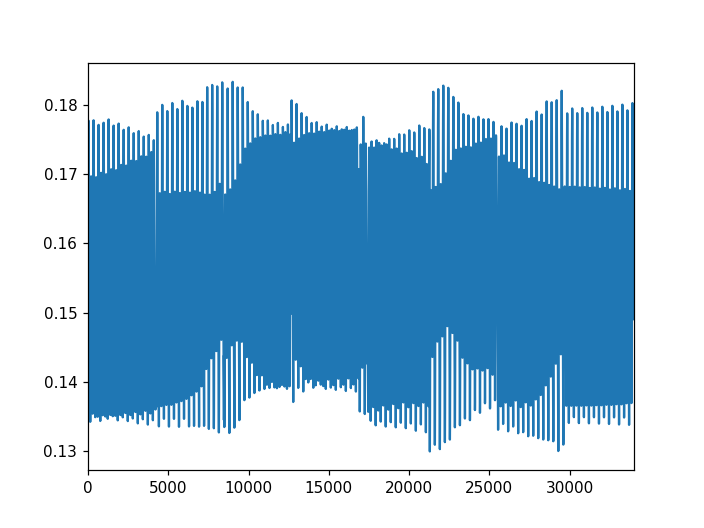

<IPython.core.display.Javascript object>


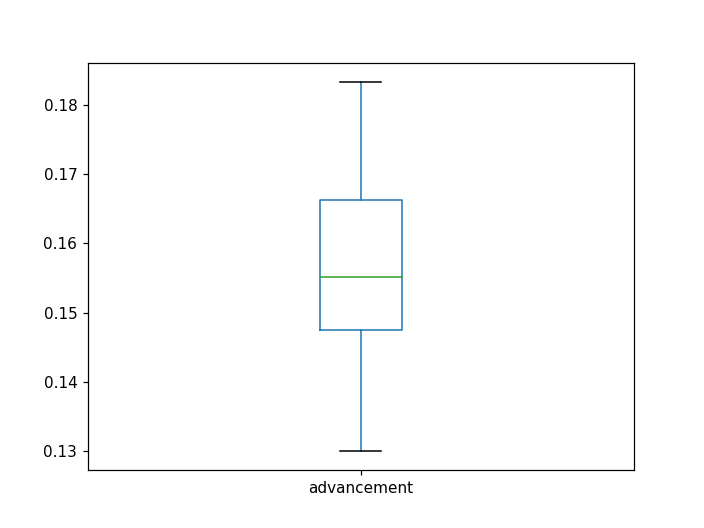

0.15637905713749872

In [54]:
fig = plt.figure()
df_total['advancement'].plot.line()

fig = plt.figure()
df_total['advancement'].plot.box()
df_total['advancement'].mean()

# Debug

<IPython.core.display.Javascript object>


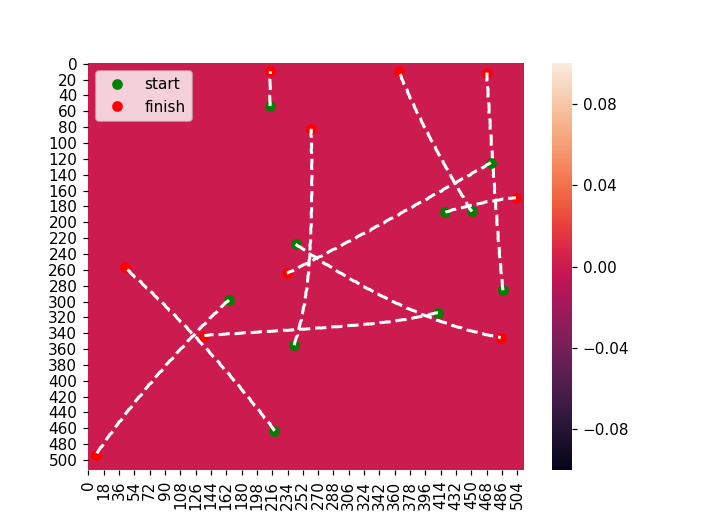

In [53]:
deb_pip = VisualiseSimulation(hm)
deb_pip.show_traces(dfs)

In [ ]:
%%html
<style>

div.output_scroll {
    height : auto !important;
}
</style>

In [46]:
def csv_path2debug(csv_path):
    idx = csvs_paths.index(csv_path)
    deb_pip(dfs[idx])
    

interact(csv_path2debug, csv_path=csvs_paths)

interactive(children=(Dropdown(description='csv_path', options=('/home/francesco/Desktop/carino/vaevictis/data…

<function __main__.csv_path2debug(csv_path)>

# Debug our coordinate function

This is krock on the simulator

![alt]("./images/bars1_krock.jpg")


In [ ]:
def to_hm_coordinates(row, hm, res, tr=[0, 0]):
    x, y = row['pose__pose_position_x'], row['pose__pose_position_y']
    x_max, y_max = hm.shape[0] * res, hm.shape[1] * res
    x_min, y_min = tr

    xs = x + x_min
    ys = -y + y_min

    return pd.Series([xs / res, ys / res])